<a href="https://colab.research.google.com/github/teidenzero/GAN/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.utils.vis_utils import plot_model
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy import expand_dims
from numpy.random import rand
from numpy.random import randint

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
#visualizing the matrix of one training example
print(trainX[0])

In [5]:
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [0]:
for i in range(25):
  pyplot.subplot(5, 5, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
# compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [0]:
model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def load_real_samples():
  (trainX, _), (_,_) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

In [0]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  return X, y


In [0]:
# generate n fake samples with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # generate ✬fake✬ class labels (0)
  y = zeros((n_samples, 1))
  return X, y

In [0]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected ✬real✬ samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # generate ✬fake✬ examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [0]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

**Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.

**Outputs**: Two-dimensional square grayscale image of 28 × 28 pixels with pixel values in
[0,1].# New Section

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

The
generator model is not compiled and does not specify a loss function or optimization algorithm.
This is because the generator is not trained directly. (see why later)

In [0]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

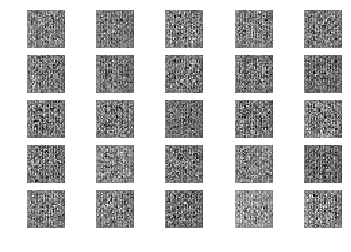

In [43]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis labels
  pyplot.axis('off')
  # plot single image
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

#Training the Generator Model

When training the generator via this logical
GAN model, there is one more important change. We want the discriminator to think that the
samples output by the generator are real, not fake. Therefore, when the generator is trained as
part of the GAN model, we will mark the generated samples as real (class = 1).

The
backpropagation process used to update the model weights will see this as a large error and will
update the model weights (i.e. only the weights in the generator) to correct for this error,

This is also why the discriminator isn't trained at the same time of the generator: otherwise it would think it's making mistakes classifying as 'fake' images labeled as 'real'.

**Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.

**Outputs**: Binary classification, likelihood the sample is real (or fake).

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model